In [1]:
%config Completer.use_jedi = False

# Importing Libraries

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from glob import glob
import regex as re
import matplotlib.pyplot as plt
import collections
import random
import requests
import time
from PIL import Image
from tqdm.auto import tqdm

/opt/anaconda3/envs/new_tensorflow/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Path where flickr images are stored
IMAGES_DIR = '/Users/mannpurohit/NEU/Capstone/Image_Captioning/archive/Flickr_Data/Images/'

In [4]:
images = glob(IMAGES_DIR+'*.jpg')
len(images)

8091

### Plot first 2 images

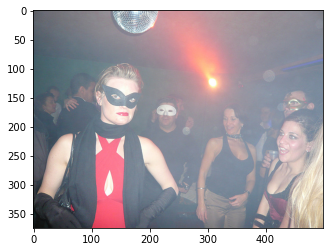

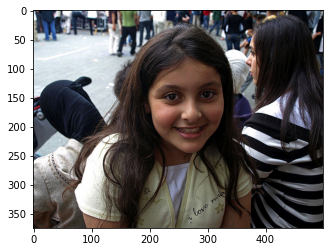

In [8]:
import matplotlib.pyplot as plt

for i in range(2):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

### Mapping Image to captions
##### Each image has 5 different captions

In [5]:
captions_dict = {}
unique_images = set()
captions_path = '/Users/mannpurohit/NEU/Capstone/Image_Captioning/archive/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'

with open(captions_path, 'r') as f:
    line = f.readline()
    while line:
        caption_id = line[:re.search(r'#[0-9]\s', line).span()[0]+2]
        image_caption = line[re.search(r'#[0-9]\s', line).span()[1]:].strip()
        captions_dict[caption_id] = image_caption
        unique_images.add(caption_id[:-2])
        line = f.readline()
#         print(line)
unique_images.remove('2258277193_586949ec62.jpg.1')

In [6]:
# train_data_ids = set()

# train_images_names_path = '/Users/mannpurohit/NEU/Capstone/Image_Captioning/archive/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
# with open(train_images_names_path, 'r') as f:
#     image_id = f.readline()
#     while image_id:
#         train_data_ids.add(image_id.strip())
#         image_id = f.readline()

##### Preprocessing Text

In [7]:
def preprocess_caption(text):
    '''
    This function will pre-process text
    '''
    
    # making it lowercase
    text = text.lower()

    # remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # remove extra spaces
    text = re.sub('\s+', ' ', text)
    text = text.strip()

    # add [start] and [end] special token
    text = '[start] ' + text + ' [end]'

    return text

In [10]:
pp_captions_dict = {} # Storing preprocessed captions
for img_id, caption in captions_dict.items():
    pp_captions_dict[img_id] = preprocess_caption(caption)

In [11]:
# Load the Inception V3 model
inception_v3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet'
)
# making training of 
inception_v3.trainable = False

##### Preprocessing Images

In [14]:
def load_image(path):
    '''
    pre-process image
    '''
    
    import tensorflow as tf

    # load image from disk
    img = tf.io.read_file(path)

    # make it a tensor
    img = tf.image.decode_jpeg(img, channels=3)

    # resize it to 300 X 300
    img = tf.image.resize(img, (300, 300))
    print('here')

    # apply inception v3 preprocessing, Normalize values from [0,255] to [-1,1]
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    return img, path

In [15]:
# train_data = {}
# for caption_id, caption in pp_captions_dict.items():
#     if '2258277193_586949ec62.jpg.1' in caption_id:
#         continue
#     image_tensor, _ = load_image('/Users/mannpurohit/NEU/Capstone/Image_Captioning/archive/Flickr_Data/Images/'+caption_id[:-2])
#     train_data[caption_id] = {'image_tensor': image_tensor, 'caption': caption}

In [16]:
# we will batch image paths using TensorFlow Dataset
image_dataset = tf.data.Dataset.from_tensor_slices([IMAGES_DIR+img_path for img_path in list(image_ids)])
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

here


In [17]:
# Let's iterate through all the image paths, load it with our
# `load_img()` function and save it in the feature_vectors 
# directory

fv_path = f'feature_vectors/'
os.makedirs(fv_path, exist_ok=True)
c = 0

for img, paths in tqdm(image_dataset, total=len(image_dataset)):
    feature_vector = inception_v3(img)
    if c == 0:
        print(feature_vector.shape)
    # the feature_vector is of shape
    # (batch_size, 8, 8, 2048)
    
    feature_vector = tf.reshape(
        feature_vector,
        (feature_vector.shape[0], -1, feature_vector.shape[3])
    )
    # now it is of shape (batch_size, 8*8, 2048) = 
    # (batch_size, 64, 2048)
    if c == 0:
        print(feature_vector.shape)
        c += 1
        
    for fv, path in zip(feature_vector, paths):
        path = path.numpy().decode("utf-8")
        path = fv_path + path.split('/')[-1]
        np.save(path, fv.numpy())

  0%|                                           | 1/506 [00:01<15:09,  1.80s/it]

(16, 8, 8, 2048)
(16, 64, 2048)


100%|█████████████████████████████████████████| 506/506 [29:47<00:00,  3.53s/it]


In [18]:
# Let's add the feature_vector column, which will 
# include the path to each image's feature vector.

captions = pd.DataFrame({'image': captions_dict.keys(), 'caption': captions_dict.values()})
captions['image'] = IMAGES_DIR + captions['image']

captions['feature_vector'] = captions['image'].apply(
    lambda x: x.replace('archive/Flickr_Data/Images/', 'feature_vectors') + '.npy'
)

captions = captions[['image', 'feature_vector', 'caption']]
captions.head()

image  \
0  /Users/mannpurohit/NEU/Capstone/Image_Captioni...   
1  /Users/mannpurohit/NEU/Capstone/Image_Captioni...   
2  /Users/mannpurohit/NEU/Capstone/Image_Captioni...   
3  /Users/mannpurohit/NEU/Capstone/Image_Captioni...   
4  /Users/mannpurohit/NEU/Capstone/Image_Captioni...   

                                      feature_vector  \
0  /Users/mannpurohit/NEU/Capstone/Image_Captioni...   
1  /Users/mannpurohit/NEU/Capstone/Image_Captioni...   
2  /Users/mannpurohit/NEU/Capstone/Image_Captioni...   
3  /Users/mannpurohit/NEU/Capstone/Image_Captioni...   
4  /Users/mannpurohit/NEU/Capstone/Image_Captioni...   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

## Text Vectorization

In [19]:
# Text vectorizer for captions
max_length = 40          # maximum number of words in sentence
vocabulary_size = 5000   # maximum vocabulary size

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,
    output_sequence_length=max_length)

# the adapt function below will build the vocabulary
tokenizer.adapt(captions['caption'])

In [20]:
# Let's test the `tokenizer`
tokenizer(['a dog running'])

<tf.Tensor: shape=(1, 40), dtype=int64, numpy=
array([[ 2, 10, 34,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])>

In [21]:
import pickle
pickle.dump(tokenizer.get_vocabulary(), open('vocab_encdec.file', 'wb'))

In [22]:
# creating word2idx and idx2word so we can easily covert word to index and vice versa

word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Train-Validation Split

In [23]:
# Train-Validation split
# fv means feature vectors

fv_to_cap_vector = collections.defaultdict(list)
for fv, cap in zip(captions['feature_vector'], captions['caption']):
    fv_to_cap_vector[fv].append(cap)

fv_keys = list(fv_to_cap_vector.keys())
random.shuffle(fv_keys)

slice_index = int(len(fv_keys)*0.8)
fv_name_train_keys, fv_name_val_keys = fv_keys[:slice_index], fv_keys[slice_index:]

train_feature_vectors = []
train_captions = []
for fvt in fv_name_train_keys:
    capt_len = len(fv_to_cap_vector[fvt])
    train_feature_vectors.extend([fvt] * capt_len)
    train_captions.extend(fv_to_cap_vector[fvt])

val_feature_vectors = []
val_captions = []
for fvv in fv_name_val_keys:
    capv_len = len(fv_to_cap_vector[fvv])
    val_feature_vectors.extend([fvv] * capv_len)
    val_captions.extend(fv_to_cap_vector[fvv])

In [24]:
print(len(train_feature_vectors), len(val_feature_vectors))

32368 8092


In [25]:
# Let's review how are train images and captions look like,
print(train_feature_vectors[0])
print()
print(train_captions[0])

/Users/mannpurohit/NEU/Capstone/Image_Captioning/feature_vectors3662406028_29b9e46a6f.jpg#4.npy

Two men in tuxedos and top-hats stand on the street as a boy with backpack passes by
